# Diamond price prediction with XGBoost and RandomizedsearchCV

In this notebook, we'll build a machine learning model to predict diamond prices using xgboost algorithm, and we'll fine-tune it using randomized searchcv to get the best hyperparameters that will give us the best predictions for this use case. We'll also make use of scikit-learn's pipeline to make our code concise and reuseable. 

### Import libraries

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

### Data exploration.

We'll import the dataset downloaded from kaggle. 
https://www.kaggle.com/datasets/deepanshsaxena1/diamond-price-predictionn

In [4]:
data = pd.read_csv('diamonds.csv')

In [5]:
data.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53940 non-null  int64  
 1   carat       53940 non-null  float64
 2   cut         53940 non-null  object 
 3   color       53940 non-null  object 
 4   clarity     53940 non-null  object 
 5   depth       53940 non-null  float64
 6   table       53940 non-null  float64
 7   price       53940 non-null  int64  
 8   x           53940 non-null  float64
 9   y           53940 non-null  float64
 10  z           53940 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


In [7]:
data.shape

(53940, 11)

In [8]:
data.describe()

,Unnamed: 0,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,26970.500000,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,15571.281097,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,1.000000,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,13485.750000,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,26970.500000,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,40455.250000,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,53940.000000,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [9]:
data.drop(['Unnamed: 0'], axis=1, inplace=True)

In [10]:
data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [11]:
data = data.drop(data[data['x']==0].index)
data = data.drop(data[data['y']==0].index)
data = data.drop(data[data['z']==0].index)

In [12]:
data['y'].max()

58.9

In [13]:
data.shape

(53920, 10)

### Visualize the data

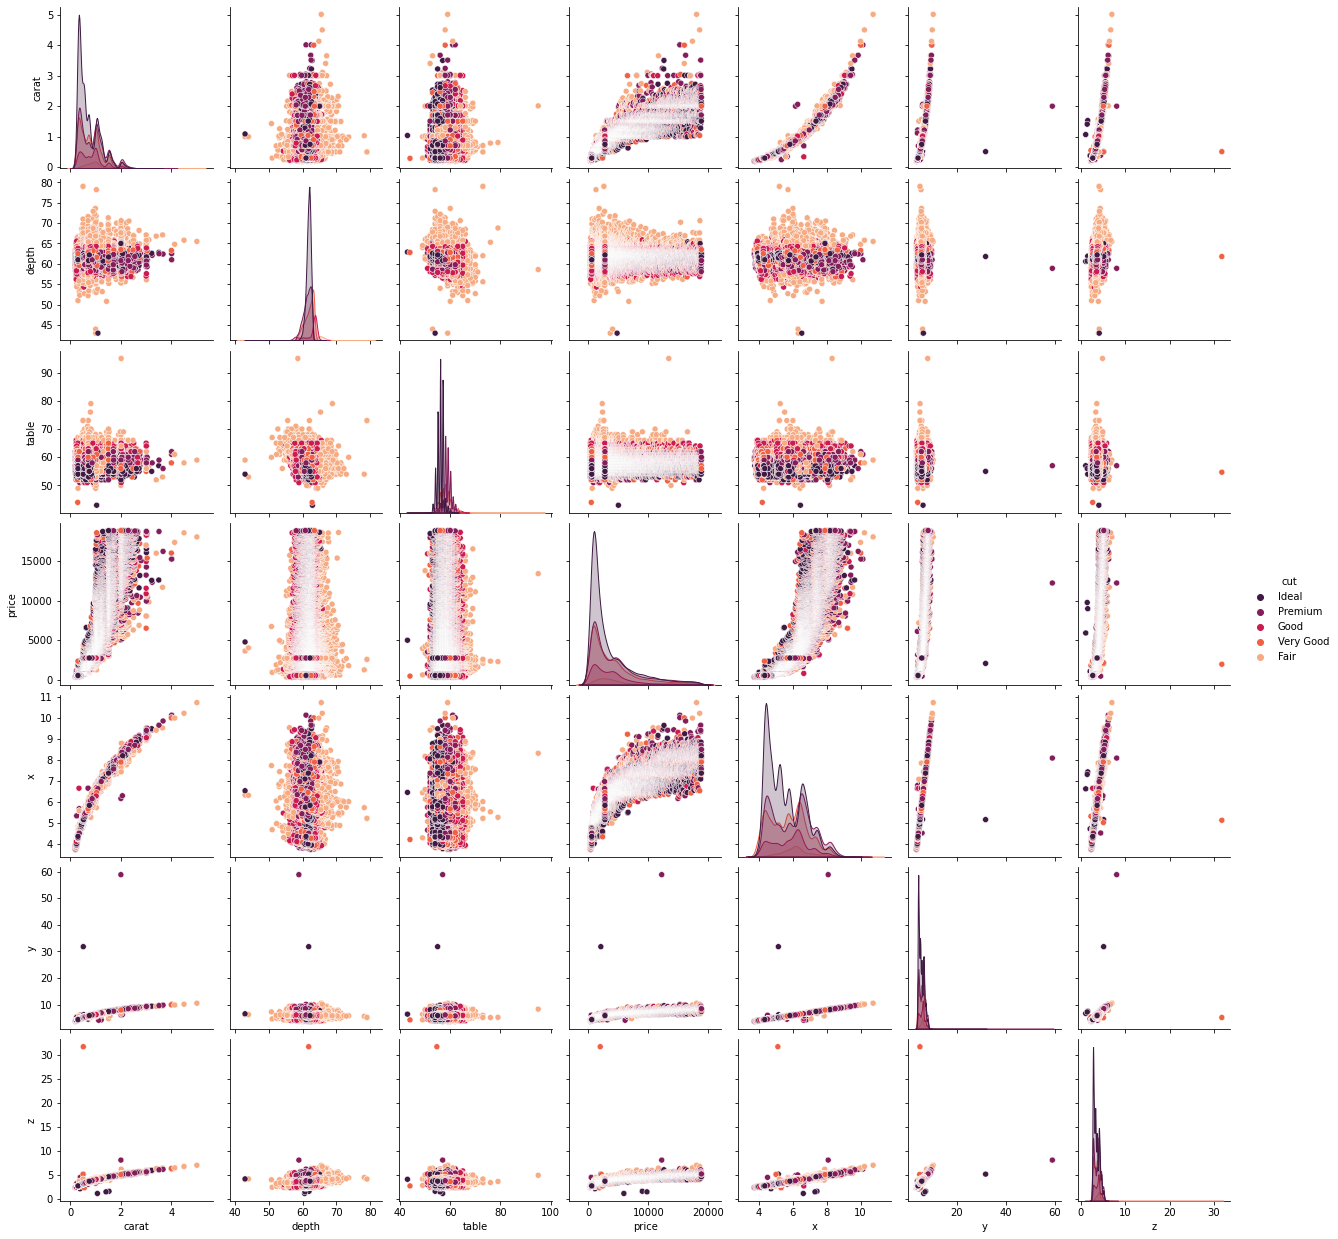

In [14]:
sns.pairplot(data, hue='cut', palette='rocket')

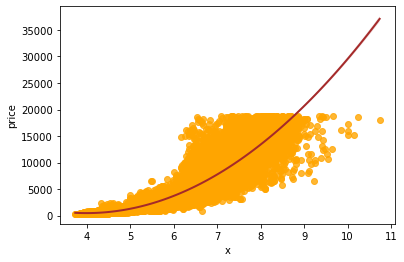

In [15]:
# plt.gca().set(xlim=(0,10.8))
plotx = sns.regplot(x='x',y='price',data=data, fit_reg=True,order=2, scatter_kws={'color':'orange'}, line_kws={'lw':2, 'color':'brown'})
                                                                          

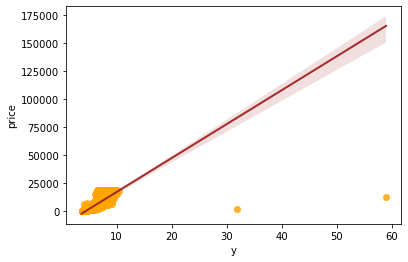

In [16]:
# plt.gca().set(xlim=(0, 59.0))
ploty = sns.regplot(x='y',y='price',data=data, fit_reg=True, scatter_kws={'color':'orange'}, line_kws={'lw':2, 'color':'brown'})

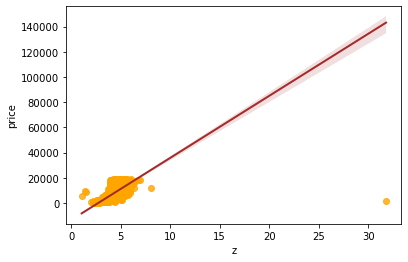

In [17]:
# plt.gca().set(xlim=(0,10.8))
plotz = sns.regplot(x='z',y='price',data=data, fit_reg=True, scatter_kws={'color':'orange'}, line_kws={'lw':2, 'color':'brown'})

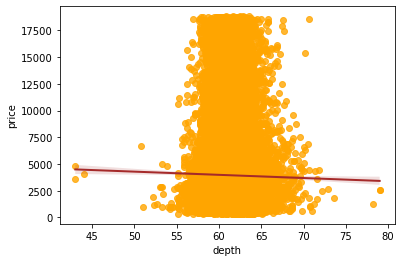

In [18]:
plot_depth = sns.regplot(x='depth',y='price',data=data, fit_reg=True, scatter_kws={'color':'orange'}, line_kws={'lw':2, 'color':'brown'})

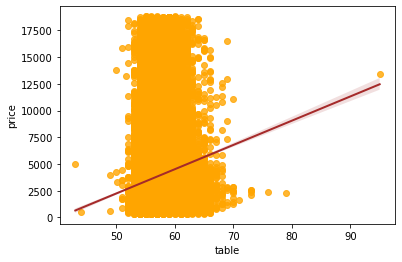

In [19]:
plot_table = sns.regplot(x='table',y='price',data=data, fit_reg=True, scatter_kws={'color':'orange'}, line_kws={'lw':2, 'color':'brown'})

In [20]:
data = data[(data['depth']<75)&(data['depth']>45)]
data = data[(data['table']<80)&(data['table']>40)]
data = data[(data['x']<30)]
data = data[(data['y']<30)]
data = data[(data['z']<30)&(data['z']>2)]
data.shape

(53907, 10)

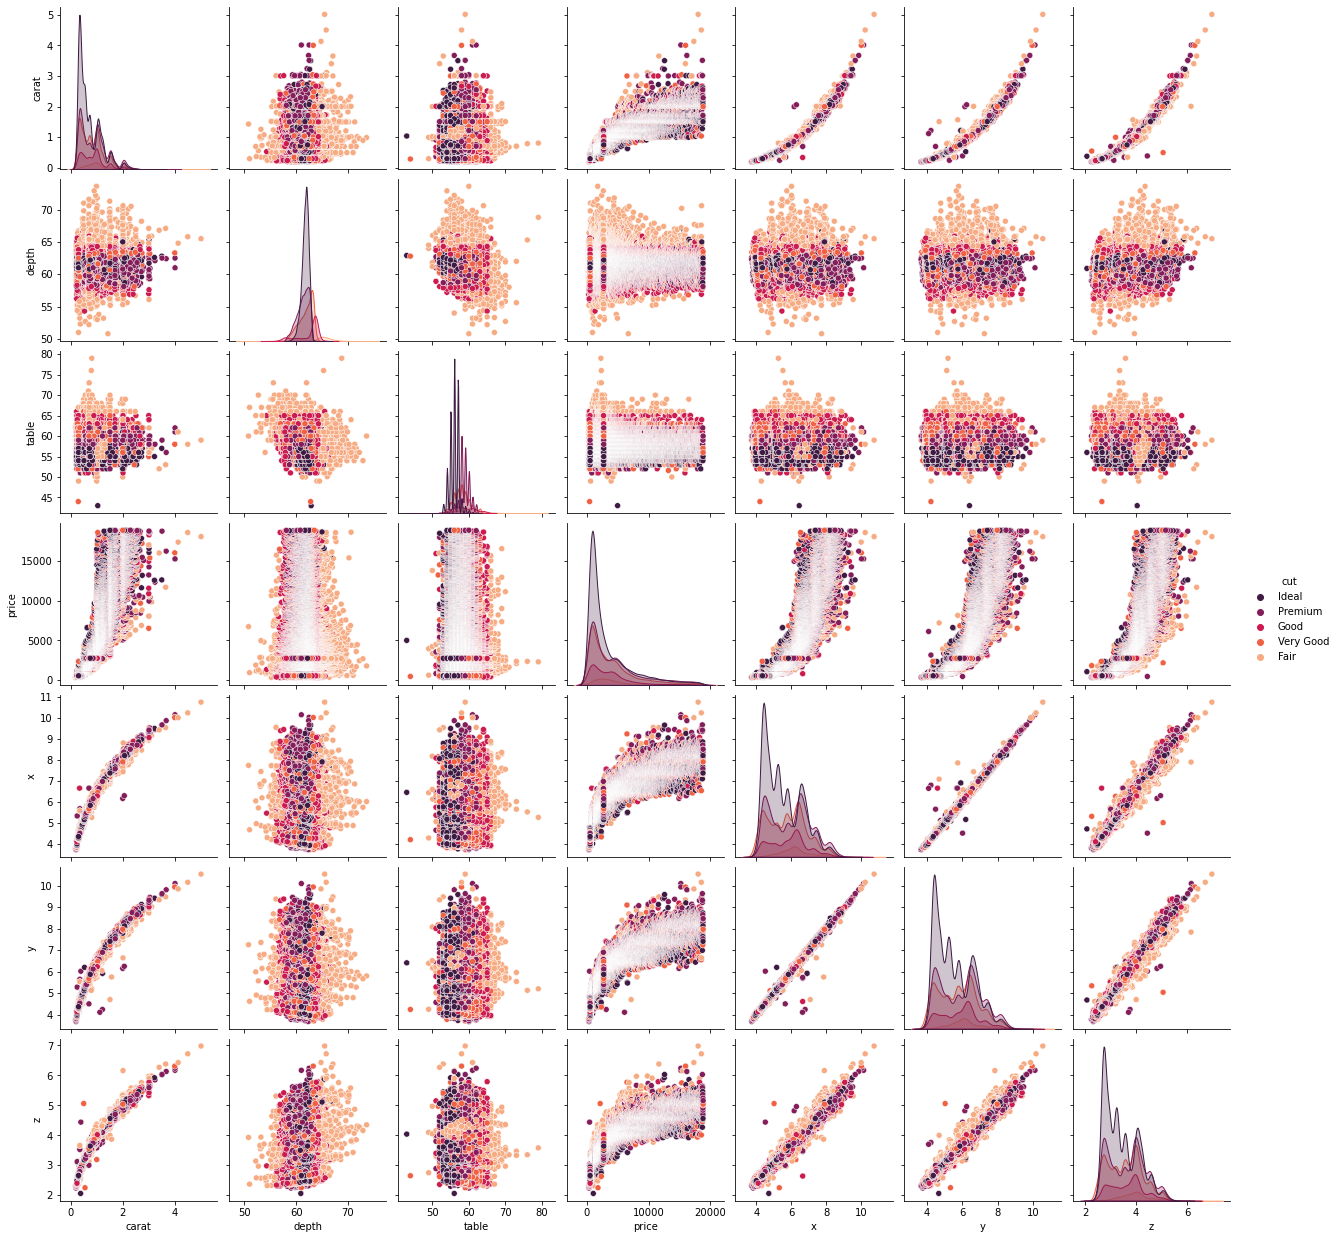

In [21]:
sns.pairplot(data, hue='cut', palette='rocket')

### Plot the data to visualize different columns with respect to price.

Text(0.5, 0, 'Color')

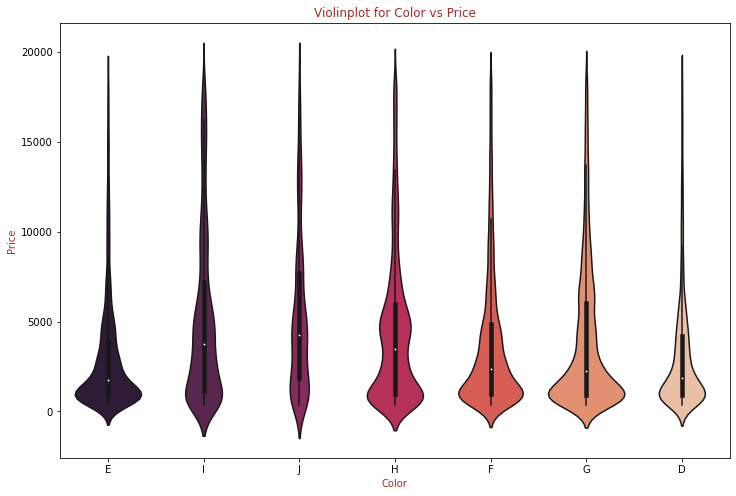

In [24]:
plt.figure(figsize=(12,8))
v_color = sns.violinplot(x='color', y='price', data=data, palette='rocket', scale='count')
v_color.set_title('Violinplot for Color vs Price', color='brown')
v_color.set_ylabel('Price', color='brown')
v_color.set_xlabel('Color', color='brown')

Text(0.5, 0, 'Clarity')

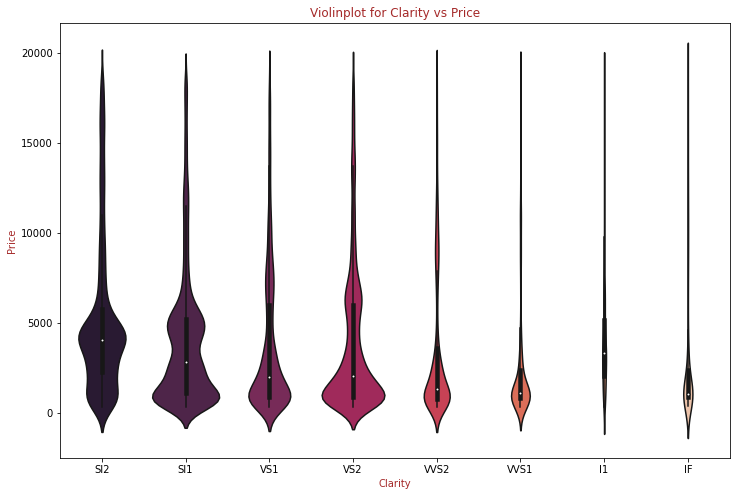

In [25]:
plt.figure(figsize=(12,8))
v_clarity = sns.violinplot(x='clarity', y='price', data=data, palette='rocket', scale='count')
v_clarity.set_title('Violinplot for Clarity vs Price', color='brown')
v_clarity.set_ylabel('Price', color='brown')
v_clarity.set_xlabel('Clarity', color='brown')

Text(0.5, 0, 'Cut')

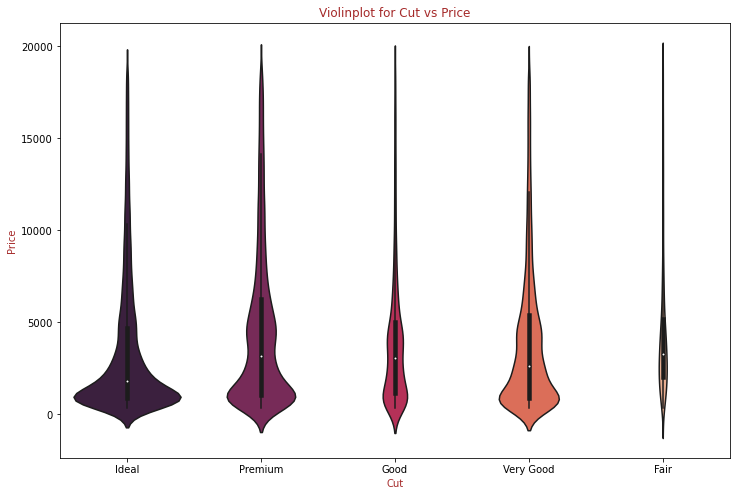

In [26]:
plt.figure(figsize=(12,8))
v_cut = sns.violinplot(x='cut', y='price', data=data, palette='rocket', scale='count')
v_cut.set_title('Violinplot for Cut vs Price', color='brown')
v_cut.set_ylabel('Price', color='brown')
v_cut.set_xlabel('Cut', color='brown')

<!-- # Label encoding -->

In [28]:
data.describe()

,carat,depth,table,price,x,y,z
count,53907.000000,53907.000000,53907.000000,53907.000000,53907.000000,53907.000000,53907.000000
mean,0.797628,61.749741,57.455948,3930.584470,5.731463,5.733292,3.539441
std,0.473765,1.420119,2.226153,3987.202815,1.119384,1.111252,0.691434
min,0.200000,50.800000,43.000000,326.000000,3.730000,3.680000,2.060000
25%,0.400000,61.000000,56.000000,949.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5322.000000,6.540000,6.540000,4.040000
max,5.010000,73.600000,79.000000,18823.000000,10.740000,10.540000,6.980000


C:\Users\Surface\AppData\Local\Temp\ipykernel_9372\160647346.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data_corr = data.corr()


<Axes: >

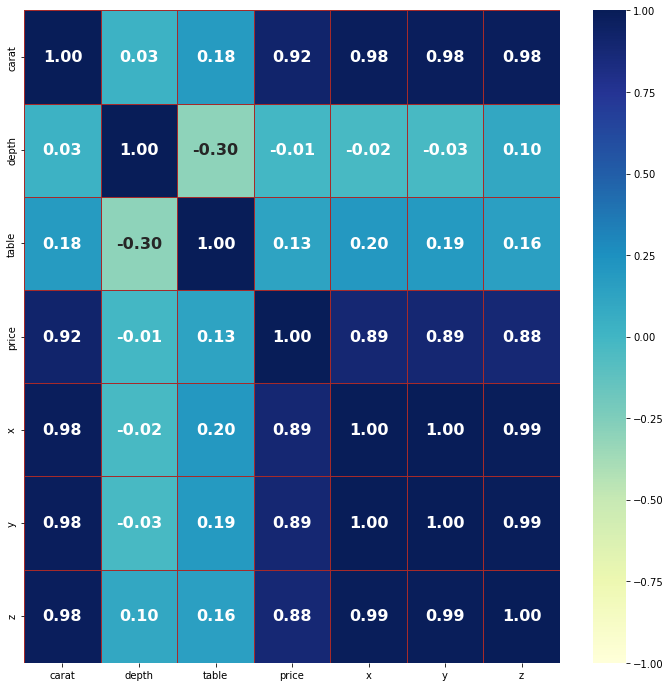

In [29]:
data_corr = data.corr()
f, ax = plt.subplots(figsize=(12,12))
sns.heatmap(data_corr,cmap='YlGnBu', center=0, vmin=-1, vmax=1, fmt='.2f', linewidth=1, linecolor='brown',annot=True, annot_kws={
    'fontsize': 16,
    'fontweight': 'bold'
})

### Split the data into training and test sets

In [30]:
x= data.drop(["price"],axis =1)
y= data["price"]
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.20, random_state=7)

### Build pipelines for preprocessing and model building.

In [31]:
# Pipeline for scaling numerical variables

num_pipeline = Pipeline([
    ('scale', StandardScaler())
])

# Pipeline for encoding categorical variables

cat_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

Sklearn provides special classes which you will also need for different tasks. For example, you may want to perform different processing on numerical and categorical features, apply a custom function to your data or apply different transformers to te same column or the whole dataframe.

We'll use the Column Transformer class to combine the num_pipeline and cat_pipeline into a single pipeline. This is the preprocessing pipeline.

In [32]:
# Both separate pipelines are now concatenated in a single 
# preprocess pipeline with Column Transformer

preprocess_pipeline = ColumnTransformer([
    ('numeric', num_pipeline, ['carat','depth','table','x','y','z']),
    ('categorical', cat_pipeline, ['cut','color','clarity'])
], remainder='passthrough')

We can now build the entire pipeline that will contain all the steps that we want to perform. In our case, we only have two steps which are preprocessing and the model.We'll give each step a name for identification which will be especially useful when we pass our pipeline to randomizedCV.

In [33]:
xgboost_pipeline = Pipeline(steps=[
    ('preprocess', preprocess_pipeline),
    ('xgb_regressor', XGBRegressor())
])

In order to use randomizedCV, we need to create a dictionary of the parameters that we want the randomizedCV to try for us. However, because we have two different pipelines in our model pipeline, we need to prefix the parameters with the name we gave to the respective pipeline step above. All the parameters belong to the xgboost regressor, so, we prefix them with xgb_regressor followed by double underscore(__). 

This is the recommended way .

In [ ]:
param_grid = {
    'xgb_regressor__n_estimators': [100, 500, 700],
    'xgb_regressor__max_depth': [3, 6, 9, 12],
    'xgb_regressor__learning_rate': [0.03, 0.05, 0.1],
    'xgb_regressor__min_child_weight': [2, 3, 5, 10],
    'xgb_regressor__booster': ['gbtree','gblinear'],
    'xgb_regressor__base_score': [0.5, 1, 1.5, 2.0]
}

We have to pass the model pipeline as the esimator to the randomizedsearchCV so that it can perform all the combinations of the hyperparameters and give us the best value for each parameter that will give us the best score on our chosen evaluation metric.

In [40]:
randomized_model = RandomizedSearchCV(xgboost_pipeline, 
                                      param_distributions=param_grid,
                                      scoring='neg_mean_squared_error', 
                                      n_jobs=-1,
                                      cv=5,
                                      random_state=42)
randomized_model.fit(x_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('numeric',
                                                                               Pipeline(steps=[('scale',
                                                                                                StandardScaler())]),
                                                                               ['carat',
                                                                                'depth',
                                                                                'table',
                                                                                'x',
                                                                                'y',
                                                                                'z']),
                                                                              ('categorical',
                                                                               Pipeline(steps=[('onehot',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['cut',
                                                                                'color',
                                                                                'clarity'])])),
                                             ('xgb_regressor',
                                              XGBRe...
                                                           random_state=None, ...))]),
                   n_jobs=-1,
                   param_distributions={'xgb_regressor__base_score': [0.5, 0.75,
                                                                      1],
                                        'xgb_regressor__booster': ['gbtree',
                                                                   'gblinear'],
                                        'xgb_regressor__learning_rate': [0.05,
                                                                         0.1,
                                                                         0.15],
                                        'xgb_regressor__max_depth': [3, 5, 10],
                                        'xgb_regressor__min_child_weight': [1,
                                                                            2,
                                                                            3],
                                        'xgb_regressor__n_estimators': [100,
                                                                        500]},
                   random_state=42, scoring='neg_mean_squared_error')

Scikit-learn pipeline displayed the different steps in our pipeline above.

In [41]:
randomized_model.best_estimator_

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  ['carat', 'depth', 'table',
                                                   'x', 'y', 'z']),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['cut', 'color',
                                                   'clarity'])])),
                ('xgb_regressor',
                 XGBRegressor(base_score=1, booster='gbtr...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.15,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=10, max_leaves=None, min_child_weight=2,
                              missing=nan, monotone_constraints=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None, predictor=None,
                              random_state=None, ...))])

We can now access the best parameters using 'best_params_' attribute.

In [43]:
randomized_model.best_params_

{'xgb_regressor__n_estimators': 100,
 'xgb_regressor__min_child_weight': 2,
 'xgb_regressor__max_depth': 10,
 'xgb_regressor__learning_rate': 0.15,
 'xgb_regressor__booster': 'gbtree',
 'xgb_regressor__base_score': 1}

Finally, we'll build the final model with the parameters suggested by randomsearchCV and fit it on our training data. 

In [46]:
final_model = XGBRegressor(
    n_estimators= 100,
    min_child_weight= 2,
    max_depth= 10,
    learning_rate= 0.15,
    booster= 'gbtree',
    base_score= 1
)

We'll reuse our previous model pipeline and thus, we dont have to preprocess our data manually. We simply change the pipeline estimator to the new model(final_xgb_regressor).

In [50]:
xgboost_pipeline = Pipeline(steps=[
    ('preprocess', preprocess_pipeline),
    ('final_xgb_regressor', final_model)
])

In [51]:
xgboost_pipeline.fit(x_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  ['carat', 'depth', 'table',
                                                   'x', 'y', 'z']),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['cut', 'color',
                                                   'clarity'])])),
                ('final_xgb_regressor',
                 XGBRegressor(base_score=1, booster...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.15,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=10, max_leaves=None, min_child_weight=2,
                              missing=nan, monotone_constraints=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None, predictor=None,
                              random_state=None, ...))])

### Predict using the test data.

In [52]:
xgboost_pipeline.predict(x_test)

array([6062.9434, 2630.9363, 4287.0444, ..., 9440.354 , 1885.4524,
        766.4785], dtype=float32)